In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

import numpy as np
import matplotlib.pyplot as plt

/home/eml/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
m_speakers = [np.array([0, 5]) for i in range(0, 18, 3)]
f_speakers = [np.array([0, -5]) for i in range(0, 18, 3)]

spk_covs = np.array([[0.25, 0], [0, 0.25]])

speaker_samples = []
for spk in m_speakers:
    samples = np.random.multivariate_normal(spk, spk_covs, 20)
    speaker_samples.append(samples)
for spk in f_speakers:
    samples = np.random.multivariate_normal(spk, spk_covs, 20)
    speaker_samples.append(samples)

(-10.0, 10.0)

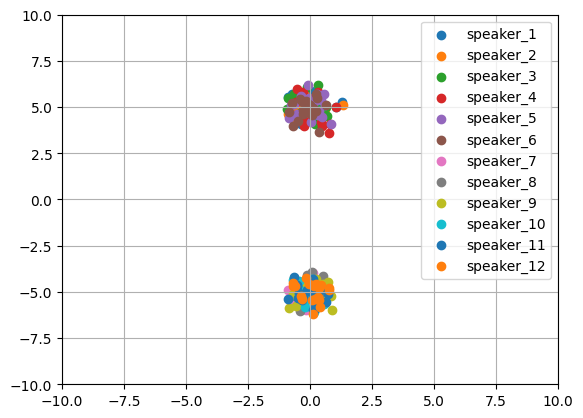

In [3]:
for idx, spk in enumerate(speaker_samples):
    plt.scatter(spk[:, 0], spk[:, 1], label=f"speaker_{idx+1}")
    
plt.legend()
plt.grid(True)
plt.xlim([-10, 10])
plt.ylim([-10, 10])

In [4]:
acc_mu1 = np.array([0, 5])
acc_mu2 = np.array([10 / np.sqrt(3), -5])
acc_mu3 = np.array([-10 / np.sqrt(3), -5])
acc_cov = np.array([[1, 0], [0, 1]])

a1_samples = np.random.multivariate_normal(acc_mu1, acc_cov, 80)
a2_samples = np.random.multivariate_normal(acc_mu2, acc_cov, 80)
a3_samples = np.random.multivariate_normal(acc_mu3, acc_cov, 80)

(-10.0, 10.0)

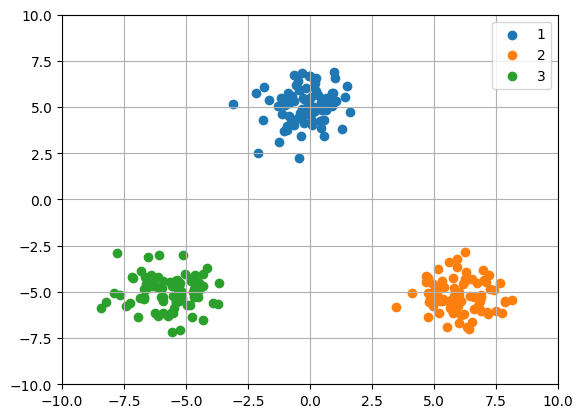

In [5]:
plt.scatter(a1_samples[:, 0], a1_samples[:, 1], label="1")
plt.scatter(a2_samples[:, 0], a2_samples[:, 1], label="2")
plt.scatter(a3_samples[:, 0], a3_samples[:, 1], label="3")

plt.legend()
plt.grid(True)
plt.xlim([-10, 10])
plt.ylim([-10, 10])

In [6]:
embed_map = {
    1: {
        "speaker_embed": speaker_samples[0],
        "accent_embed": a1_samples[0:20, :]
    },
    2: {
        "speaker_embed": speaker_samples[1],
        "accent_embed": a1_samples[20:40, :]
    },
    3: {
        "speaker_embed": speaker_samples[2],
        "accent_embed": a2_samples[0:20, :]
    },
    4: {
        "speaker_embed": speaker_samples[3],
        "accent_embed": a3_samples[0:20, :]
    },
    5: {
        "speaker_embed": speaker_samples[4],
        "accent_embed": a3_samples[20:40, :]
    },
    6: {
        "speaker_embed": speaker_samples[5],
        "accent_embed": a3_samples[40:60, :]
    },
    7: {
        "speaker_embed": speaker_samples[6],
        "accent_embed": a1_samples[40:60, :]
    },
    8: {
        "speaker_embed": speaker_samples[7],
        "accent_embed": a1_samples[60:80, :]
    },
    9: {
        "speaker_embed": speaker_samples[8],
        "accent_embed": a2_samples[20:40, :]
    },
    10: {
        "speaker_embed": speaker_samples[9],
        "accent_embed": a2_samples[40:60, :]
    },
    11: {
        "speaker_embed": speaker_samples[10],
        "accent_embed": a2_samples[60:80, :]
    },
    12: {
        "speaker_embed": speaker_samples[11],
        "accent_embed": a3_samples[60:80, :]
    }
}

(-10.0, 10.0)

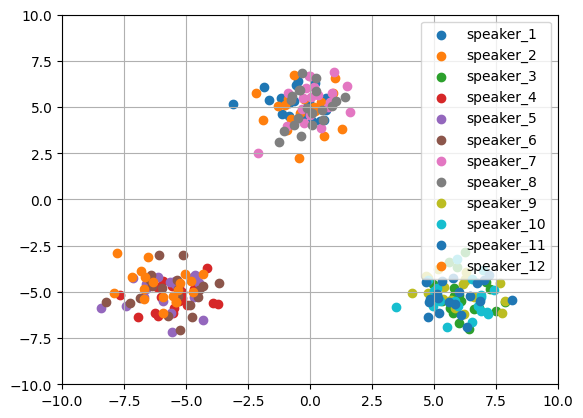

In [7]:
for spk, embed in embed_map.items():
    plt.scatter(embed["accent_embed"][:, 0], embed["accent_embed"][:, 1], label=f"speaker_{spk}")
    
plt.legend()
plt.grid(True)
plt.xlim([-10, 10])
plt.ylim([-10, 10])

In [8]:
((6 * np.log2(1.5)) + (2 * np.log2(0.5))) / 12

0.12581458369391144

In [9]:
batch_size = 5
sample_spk = np.random.choice([spk for spk in embed_map.keys()])
marge_spk = np.random.choice([spk for spk in embed_map.keys() if spk != sample_spk])

num_spk_samples = embed_map[sample_spk]["speaker_embed"].shape[0]
num_acc_samples = embed_map[sample_spk]["accent_embed"].shape[0]

sp_idx = np.random.choice(num_spk_samples, size=batch_size)
acc_idx_same = np.random.choice(num_acc_samples, size=batch_size)
acc_idx_diff = np.random.choice(num_acc_samples, size=batch_size)

sp_sample = embed_map[sample_spk]["speaker_embed"][sp_idx]
ac_sample_same = embed_map[sample_spk]["accent_embed"][acc_idx_same]
ac_sample_diff = embed_map[marge_spk]["accent_embed"][acc_idx_diff]

joint_sample = np.concatenate([sp_sample, ac_sample_same], axis=1)
marginal_sample = np.concatenate([sp_sample, ac_sample_diff], axis=1)

print(f"Joint: {joint_sample}")
print(f"Marginal: {marginal_sample}")

Joint: [[ 1.05752954  5.00136013  0.0860048   4.23342391]
 [ 0.02931594  5.88709563 -0.3426907   4.36361202]
 [ 0.36864225  4.28221081  0.21579813  6.30783949]
 [-0.37596105  4.06735552 -0.3426907   4.36361202]
 [-0.39055961  5.54772703  0.21579813  6.30783949]]
Marginal: [[ 1.05752954  5.00136013 -6.33315251 -4.46073694]
 [ 0.02931594  5.88709563 -5.2468421  -4.53859523]
 [ 0.36864225  4.28221081 -4.73815602 -4.9960211 ]
 [-0.37596105  4.06735552 -6.68029061 -5.3776264 ]
 [-0.39055961  5.54772703 -5.41713254 -5.56322276]]


In [10]:
class Mine(nn.Module):
    def __init__(self, input_size=4, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output

In [11]:
def mutual_information(joint, marginal, mine_net):
    t = mine_net(joint)
    et = torch.exp(mine_net(marginal))
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et

def learn_mine(batch, mine_net, mine_net_optim,  ma_et, ma_rate=0.01):
    # batch is a tuple of (joint, marginal)
    joint , marginal = batch
    joint = torch.autograd.Variable(torch.FloatTensor(joint)).cuda()
    marginal = torch.autograd.Variable(torch.FloatTensor(marginal)).cuda()
    mi_lb , t, et = mutual_information(joint, marginal, mine_net)
    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)
    
    # unbiasing use moving average
    loss = -(torch.mean(t) - (1/ma_et.mean()).detach()*torch.mean(et))
    # use biased estimator
#     loss = - mi_lb
    
    mine_net_optim.zero_grad()
    autograd.backward(loss)
    mine_net_optim.step()
    return mi_lb, ma_et

In [12]:
def sample_batch(data, batch_size=100, sample_mode='joint'):
    sample_spk = np.random.choice([spk for spk in data.keys()])
    num_spk_samples = data[sample_spk]["speaker_embed"].shape[0]
    spk_idx = np.random.choice(num_spk_samples, size=batch_size)
    spk_sample = data[sample_spk]["speaker_embed"][spk_idx]
    
    num_acc_samples = data[sample_spk]["accent_embed"].shape[0]
    acc_idx = np.random.choice(num_acc_samples, size=batch_size)
    
    if sample_mode == "joint":
        acc_sample = data[sample_spk]["accent_embed"][acc_idx]
    else:  
        marge_spk = np.random.choice([spk for spk in data.keys() if spk != sample_spk])
        acc_sample = data[marge_spk]["accent_embed"][acc_idx]
    
    return np.concatenate([spk_sample, acc_sample], axis=1)

In [55]:
def train(data, mine_net,mine_net_optim, batch_size=100, iter_num=int(1e+6), log_freq=int(2e+5)):
    # data is embed_map (dict of speaker and accent embeddings for each speaker)
    result = list()
    ma_et = 1.
    for i in range(iter_num):
        batch = sample_batch(data,batch_size=batch_size)\
        , sample_batch(data,batch_size=batch_size,sample_mode='marginal')
        mi_lb, ma_et = learn_mine(batch, mine_net, mine_net_optim, ma_et)
        result.append(mi_lb.detach().cpu().numpy())
        if (i+1)%(log_freq)==0:
            print(result[-1])
    return result

In [56]:
def ma(a, window_size=1000):
    return [np.mean(a[i:i+window_size]) for i in range(0,len(a)-window_size)]

In [57]:
mine_net_test = Mine().cuda()
mine_net_optim = optim.Adam(mine_net_test.parameters(), lr=1e-5)
result_test = train(embed_map, mine_net_test, mine_net_optim)

-0.008638665
0.40605375
0.016684711
0.36948043
1.2514783


0.18154755


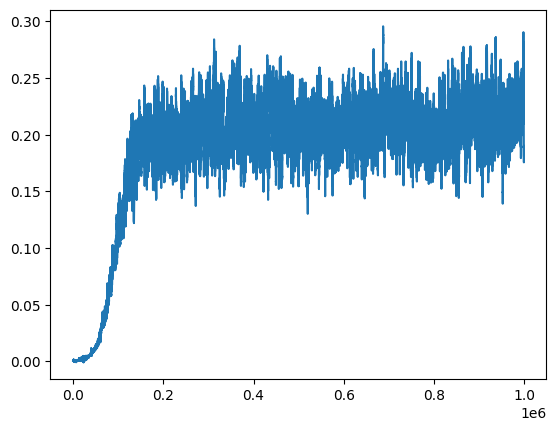

In [58]:
result_test_ma = ma(result_test)
print(result_test_ma[-1])
plt.plot(range(len(result_test_ma)), result_test_ma)